# INTRODUCTION

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


# Import needed libraries 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# About dataset 

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on *  * public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Load Data

In [4]:
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

/tmp/ipykernel_33/1080380595.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


In [4]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
test.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [6]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

# EDA and Analysis 

## Check for missing values in train dataset

In [7]:
print(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [8]:
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


**That is good that we have not missing values**

## Sales trends over time

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

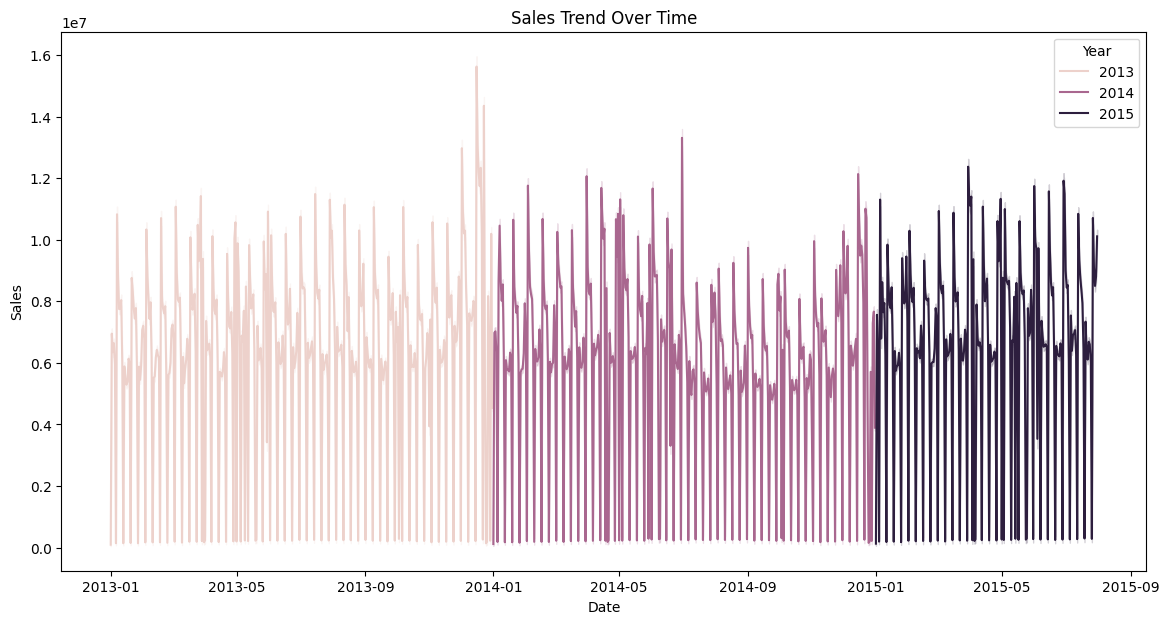

In [9]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=train, x='Date', y='Sales', hue='Year', estimator='sum')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

**We cant catch info from this graph** 

## Sales by Store Type

In [11]:
# Merge the datasets
train = train.merge(store, how='left', on='Store')
test = test.merge(store, how='left', on='Store')

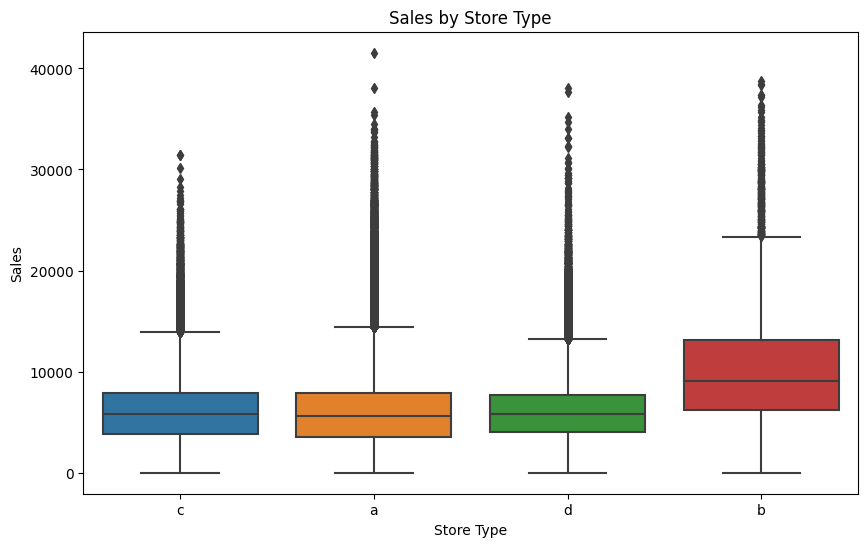

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='StoreType', y='Sales')
plt.title('Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

**We can see that stores with type 'b' achive more sales** 

## Sales by Assortment Type

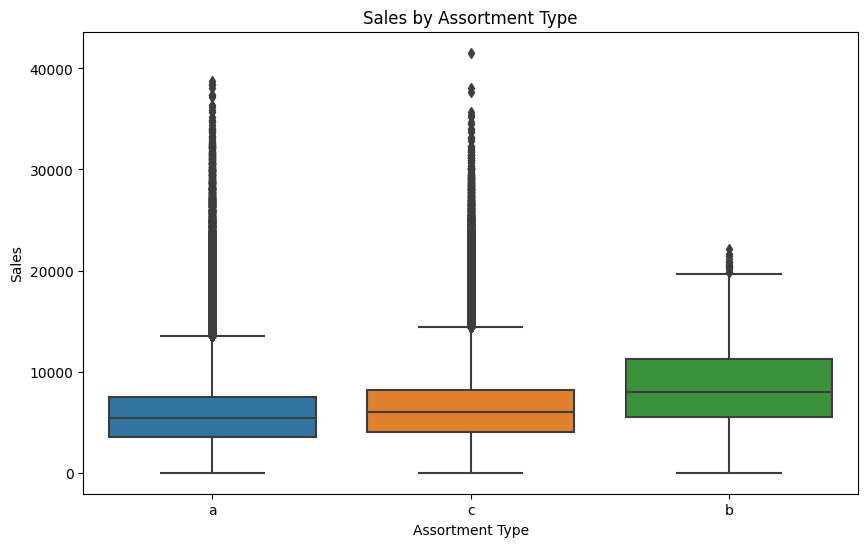

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='Assortment', y='Sales')
plt.title('Sales by Assortment Type')
plt.xlabel('Assortment Type')
plt.ylabel('Sales')
plt.show()

**We can see that stores with Assortment type 'b' achive more sales** 

## Sales by Day of Week

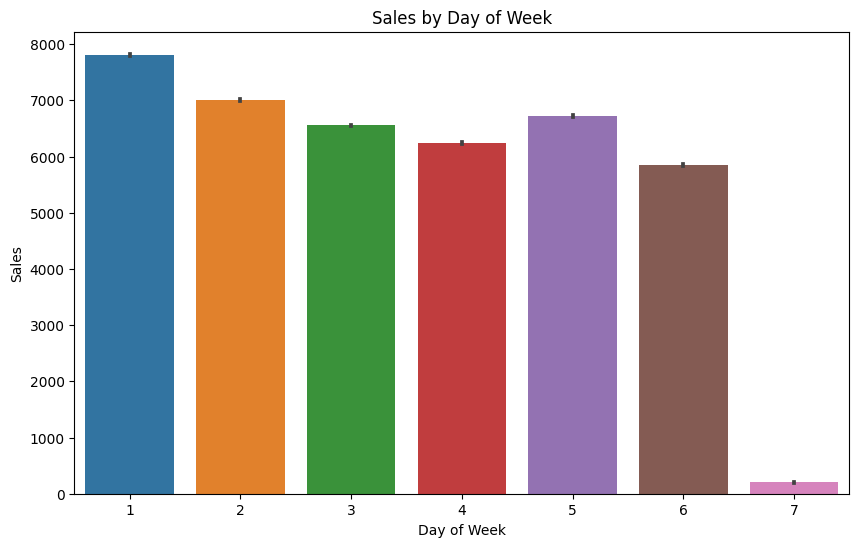

In [11]:

plt.figure(figsize=(10, 6))
sns.barplot(data=train, x='DayOfWeek', y='Sales')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()


## Sales by Promo

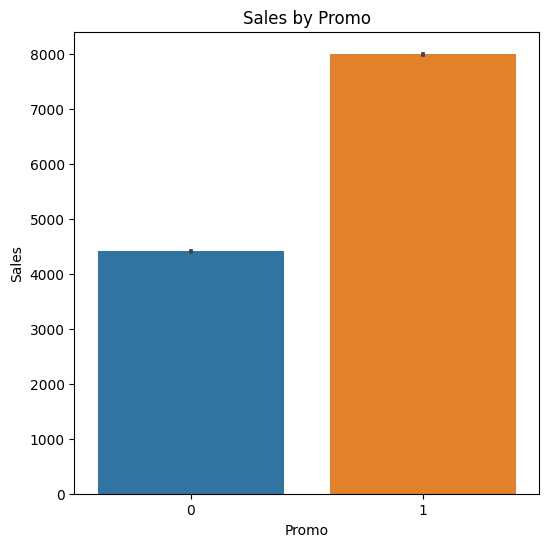

In [13]:
plt.figure(figsize=(6, 6))
sns.barplot(data=train, x='Promo', y='Sales')
plt.title('Sales by Promo')
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.show()

## Sales by Month

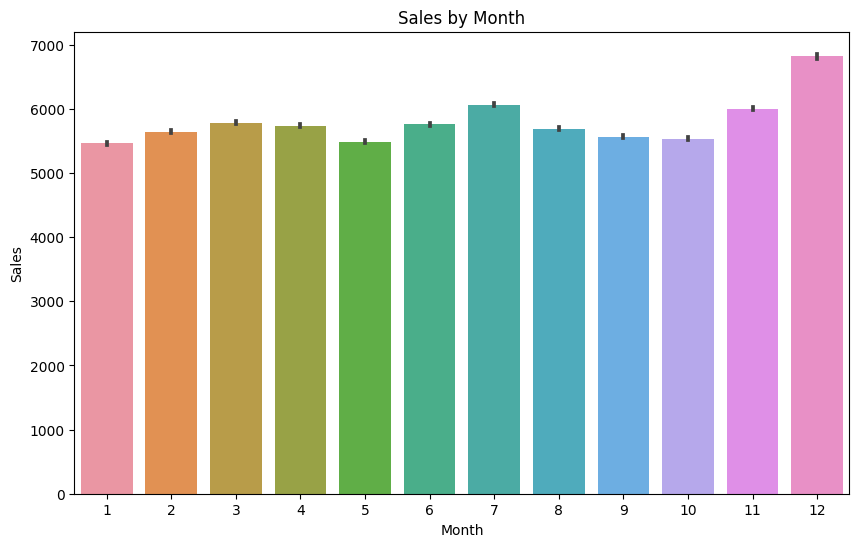

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=train, x='Month', y='Sales')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

we can see that sales are higher in the months of July, August and September.

## Sales by StateHoliday

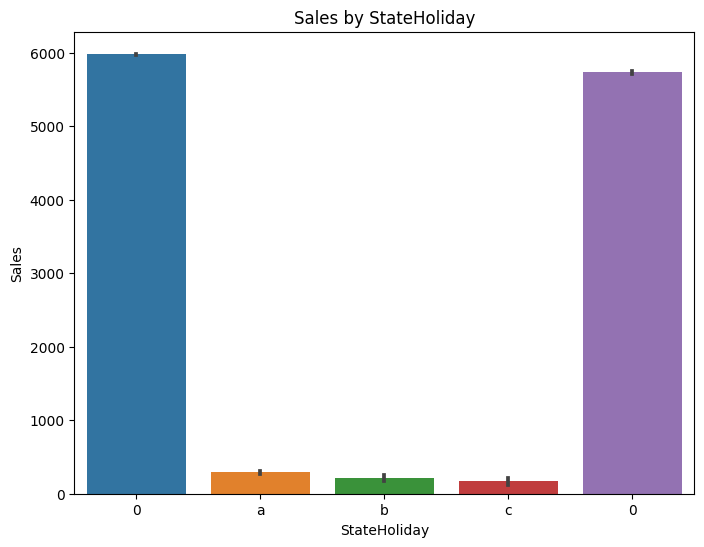

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(data=train, x='StateHoliday', y='Sales')
plt.title('Sales by StateHoliday')
plt.xlabel('StateHoliday')
plt.ylabel('Sales')
plt.show()

we can see that there is inconsistent in values of StateHoliday.<br>
both of 0 and '0' indicate to >> none. <br>
sales in none holidays are higher.

## Sales by SchoolHoliday


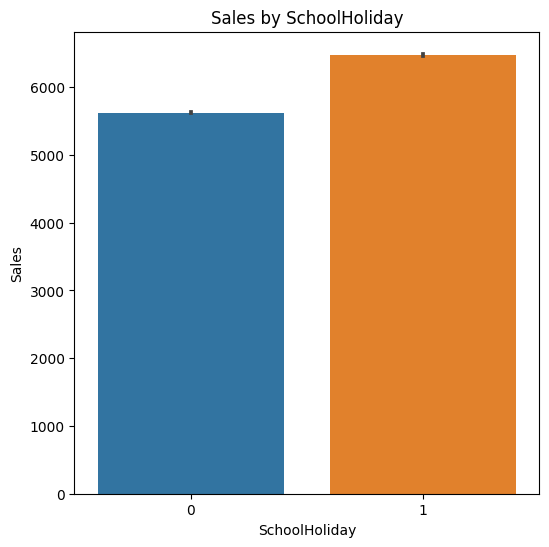

In [17]:
plt.figure(figsize=(6, 6))
sns.barplot(data=train, x='SchoolHoliday', y='Sales')
plt.title('Sales by SchoolHoliday')
plt.xlabel('SchoolHoliday')
plt.ylabel('Sales')
plt.show()

More sales in shool holiday days.

## Correlation Matrix

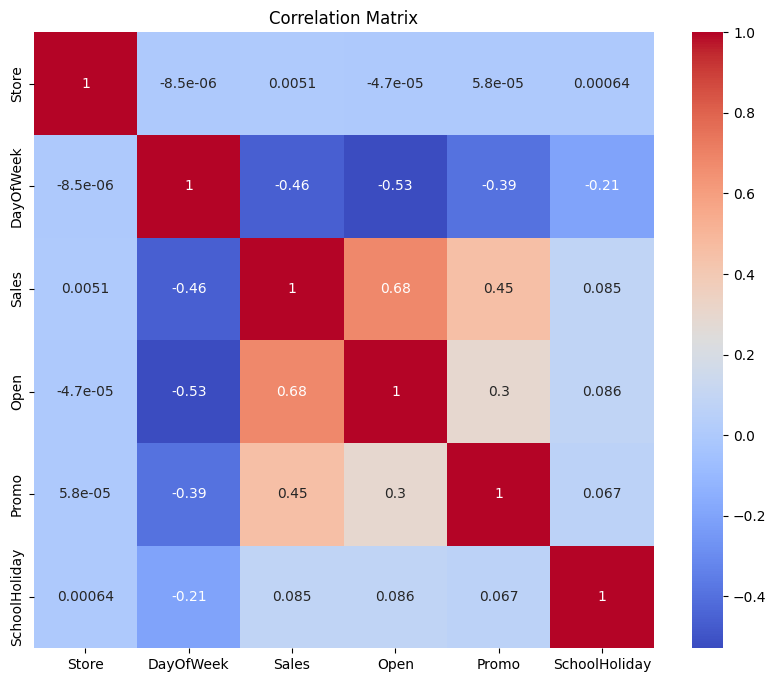

In [28]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('Customers')
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**previous analyses can provide deeper insights into the relationships between various features and sales.**

## Decompose the time series
I will choose
* random store from each type.
* different periods and decompose the time series.

In [14]:
# Create a copy of the DataFrame with 'Date' as index
train_df = train.set_index('Date').copy()

In [15]:
# Get one random store from each store type
stores_by_type = train_df.groupby('StoreType')['Store'].unique()
stores_to_analyze = [random.choice(store_list) for store_list in stores_by_type]

In [16]:
# Define a list of periods to try
periods_to_try = [7, 30, 365]  #  daily, monthly, and yearly

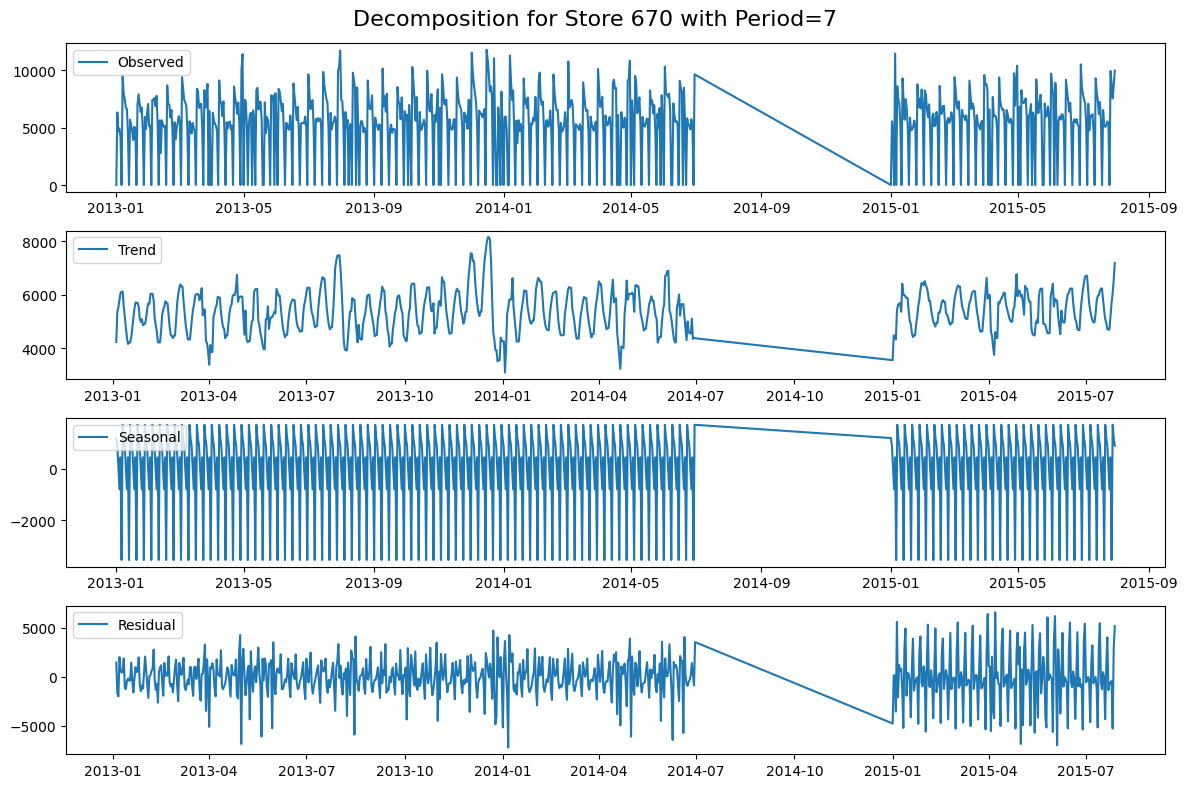

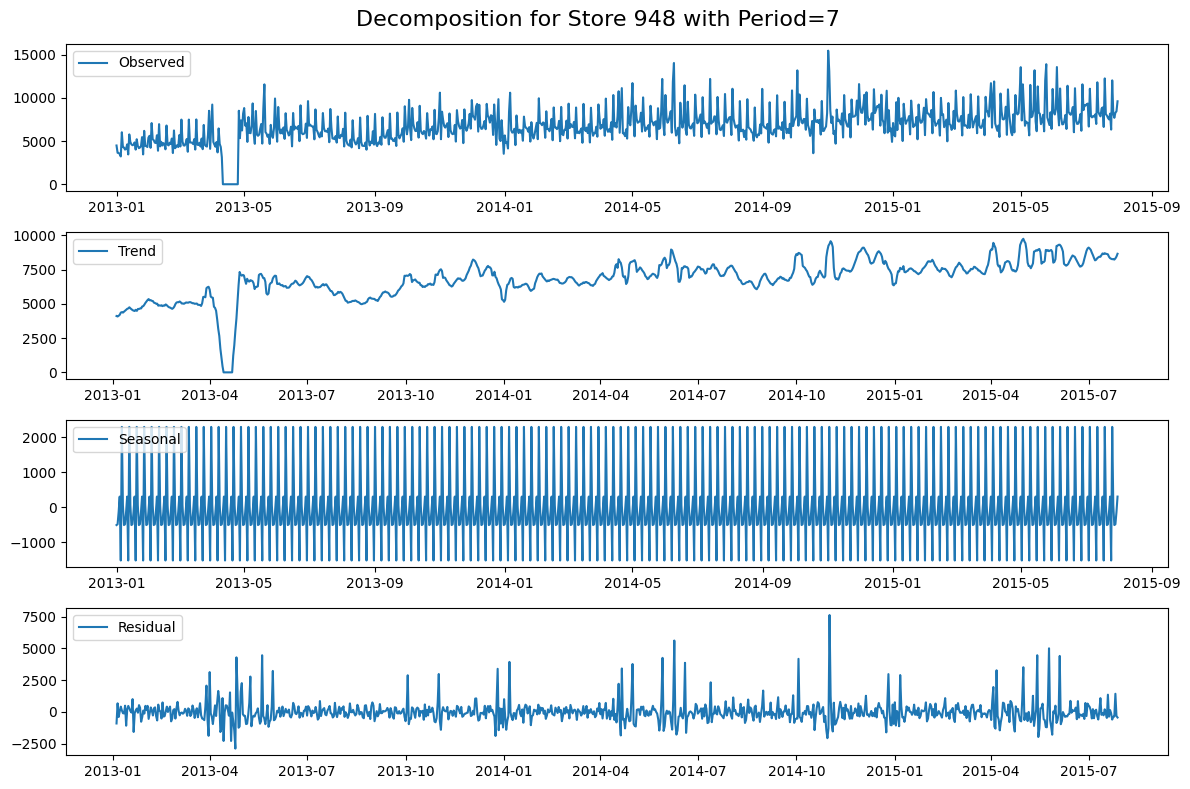

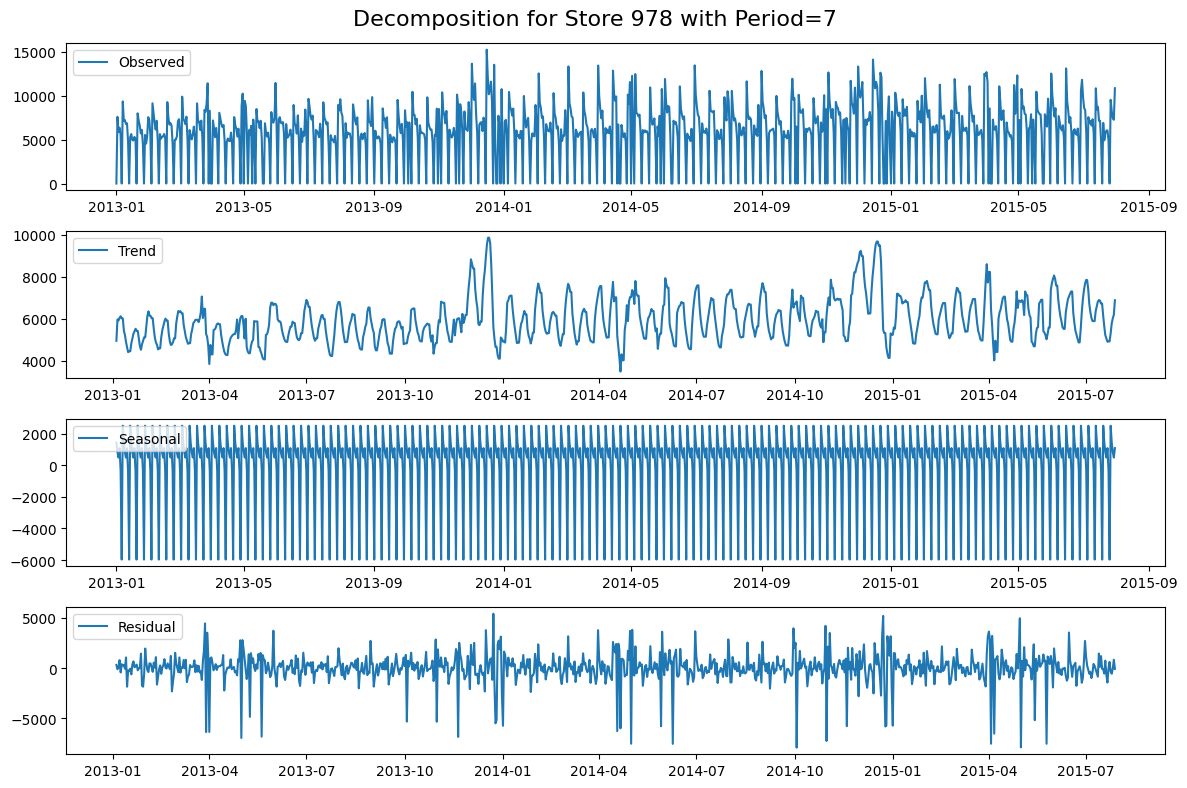

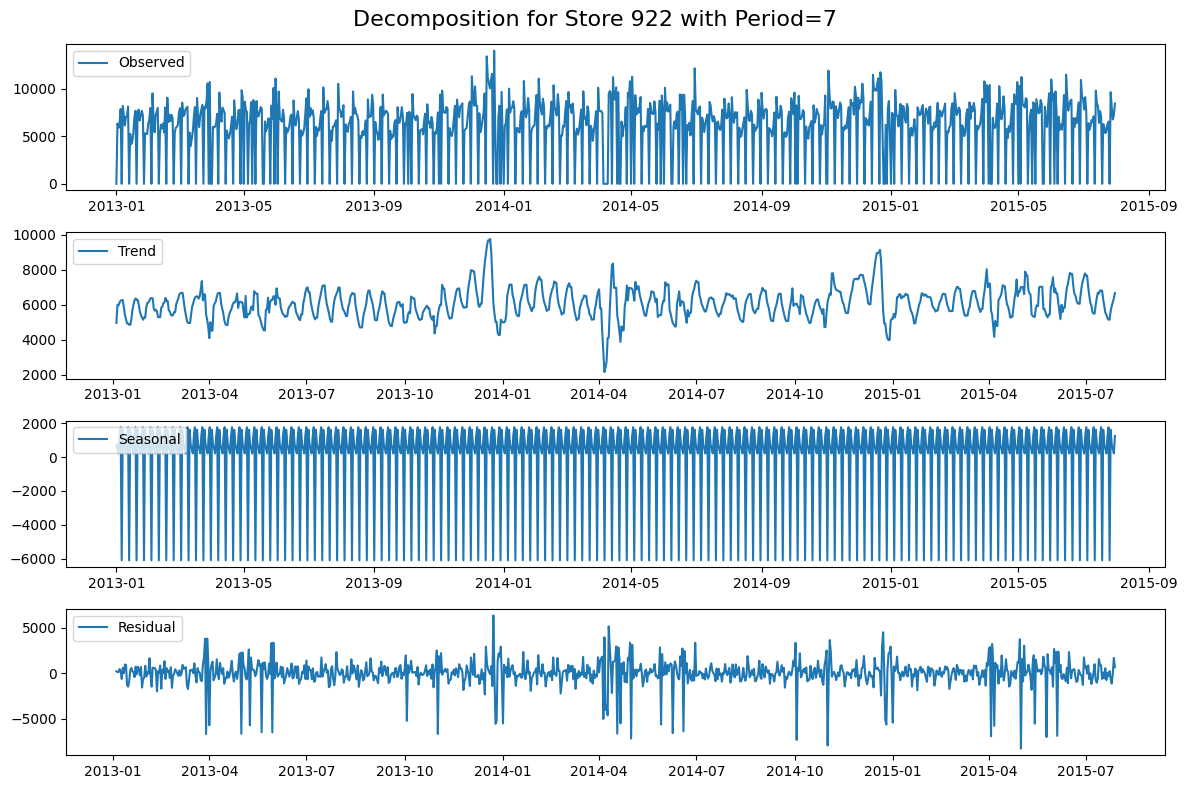

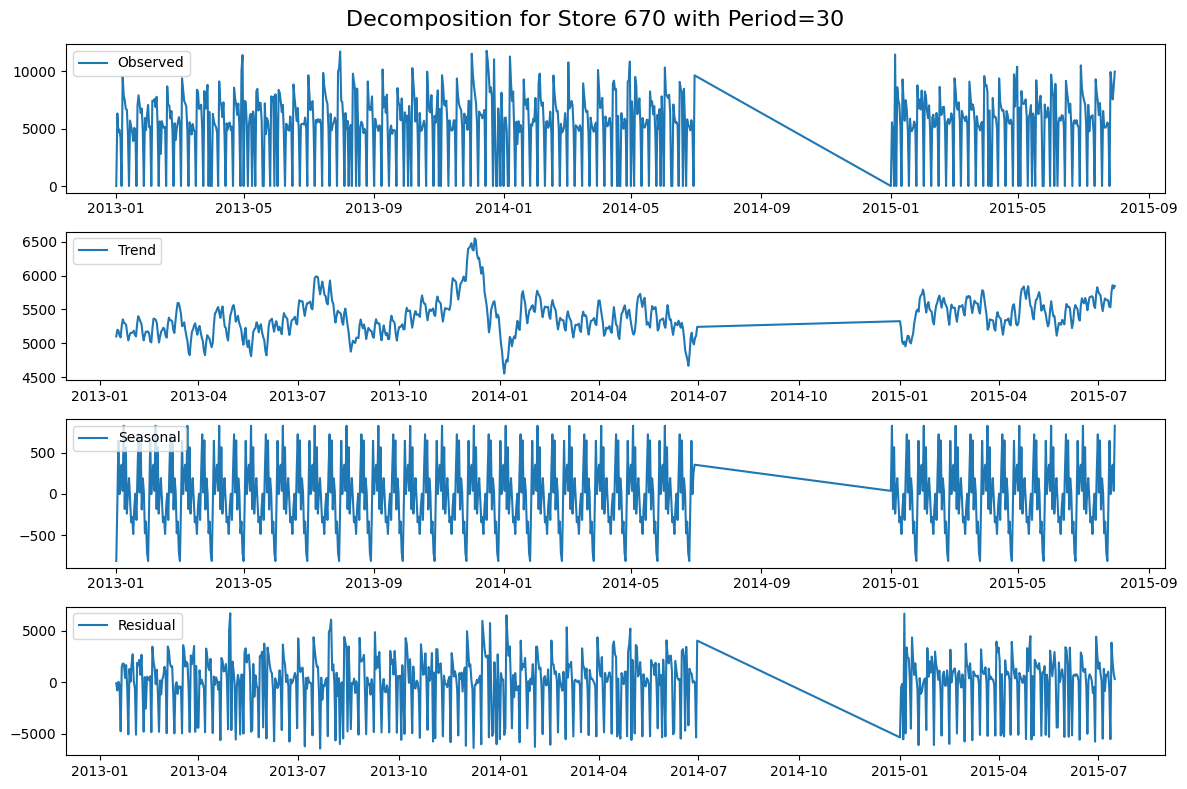

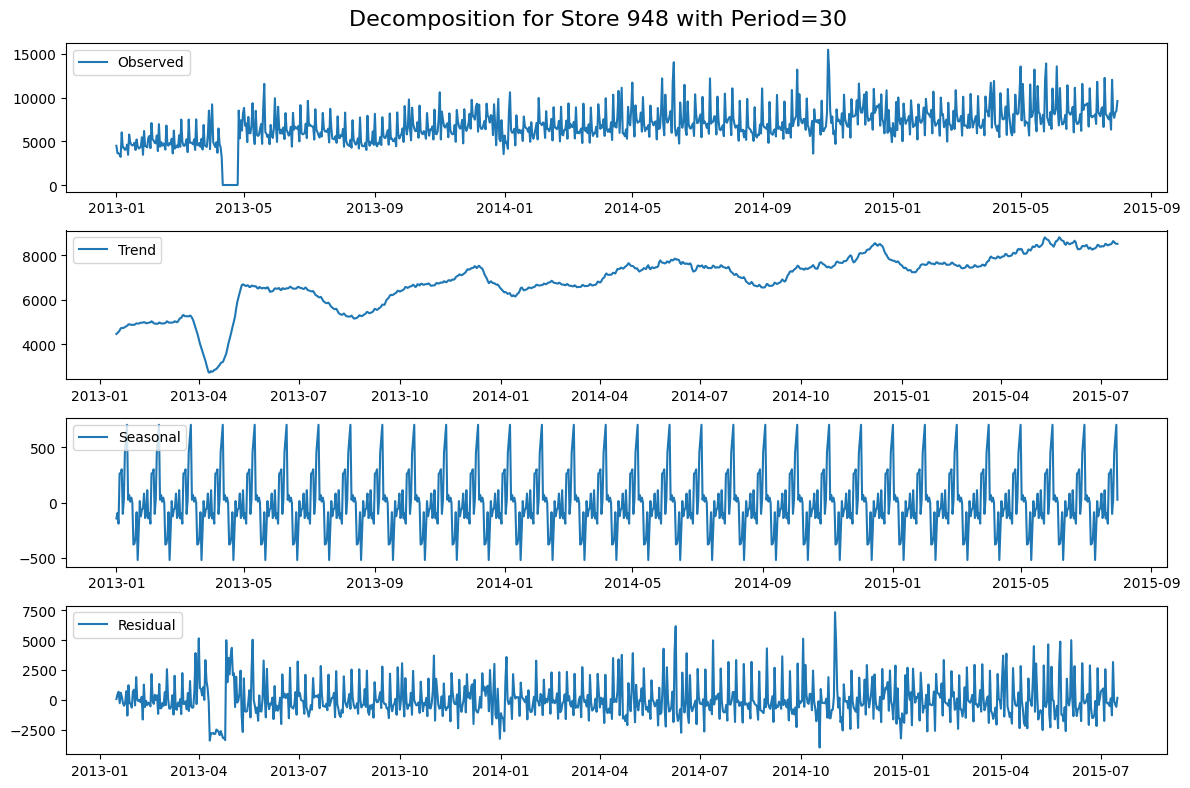

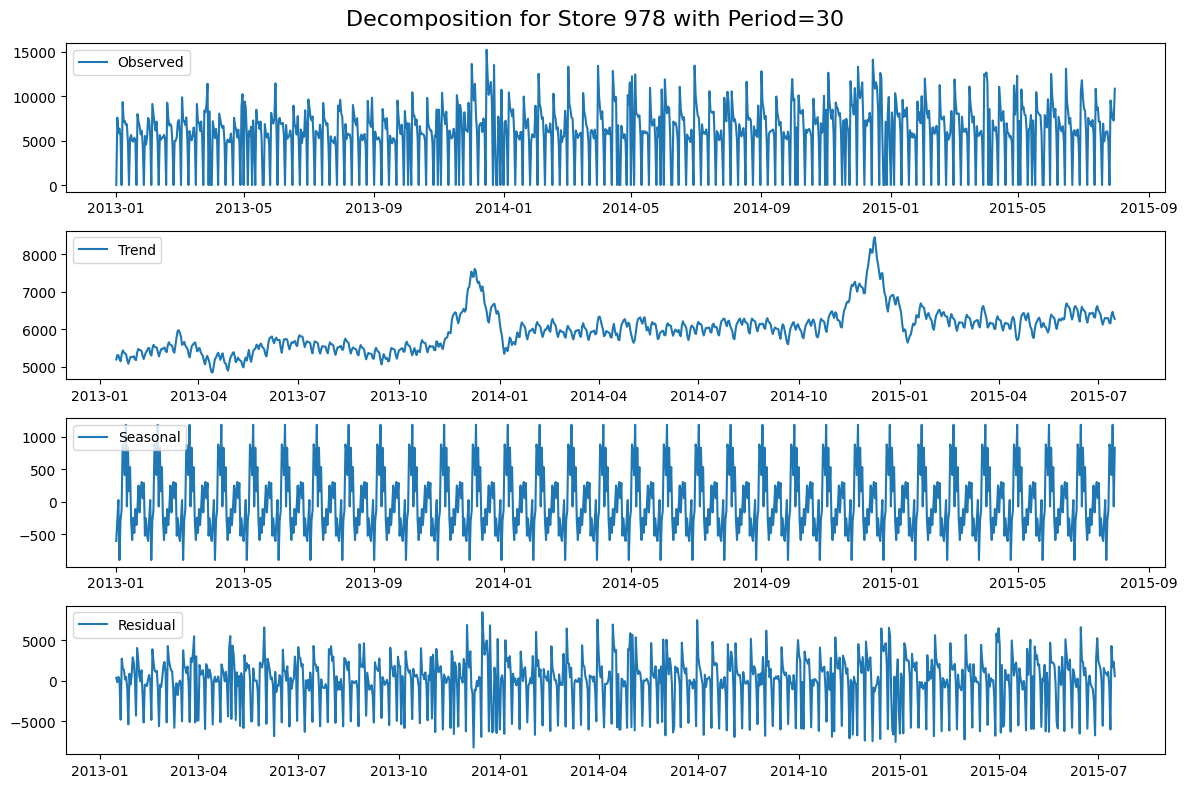

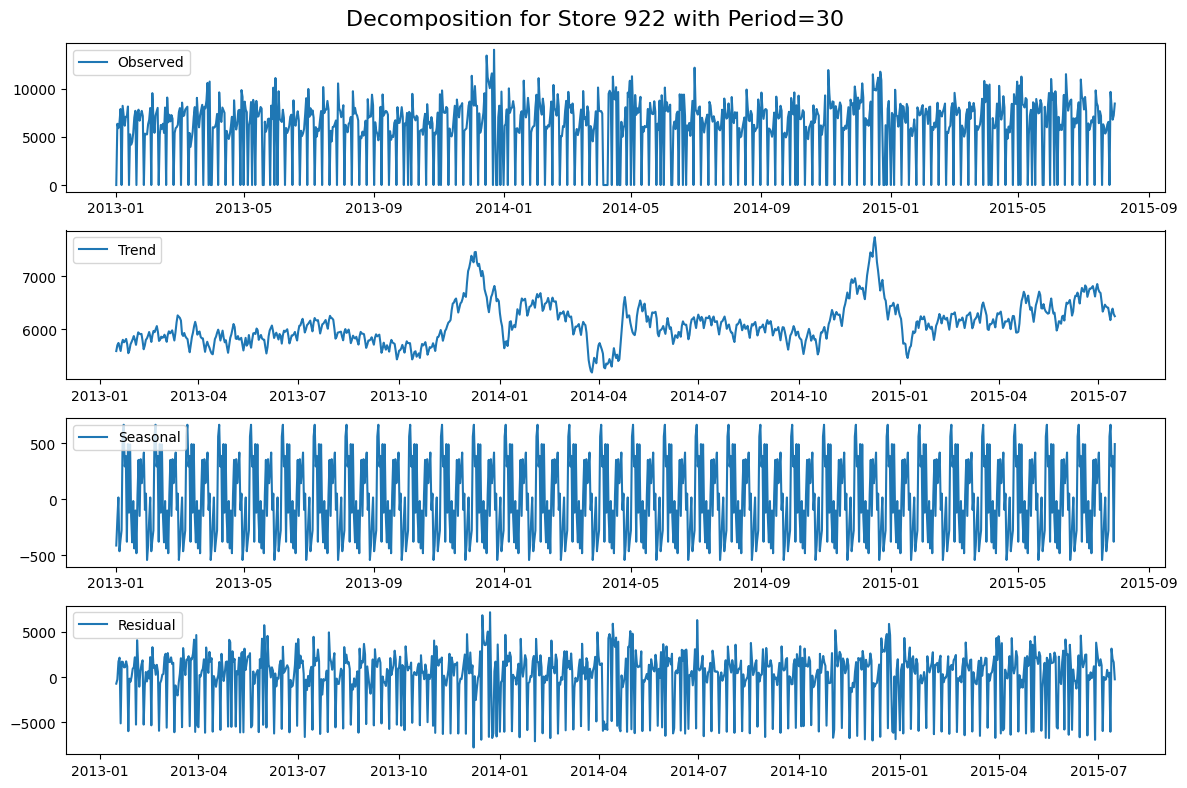

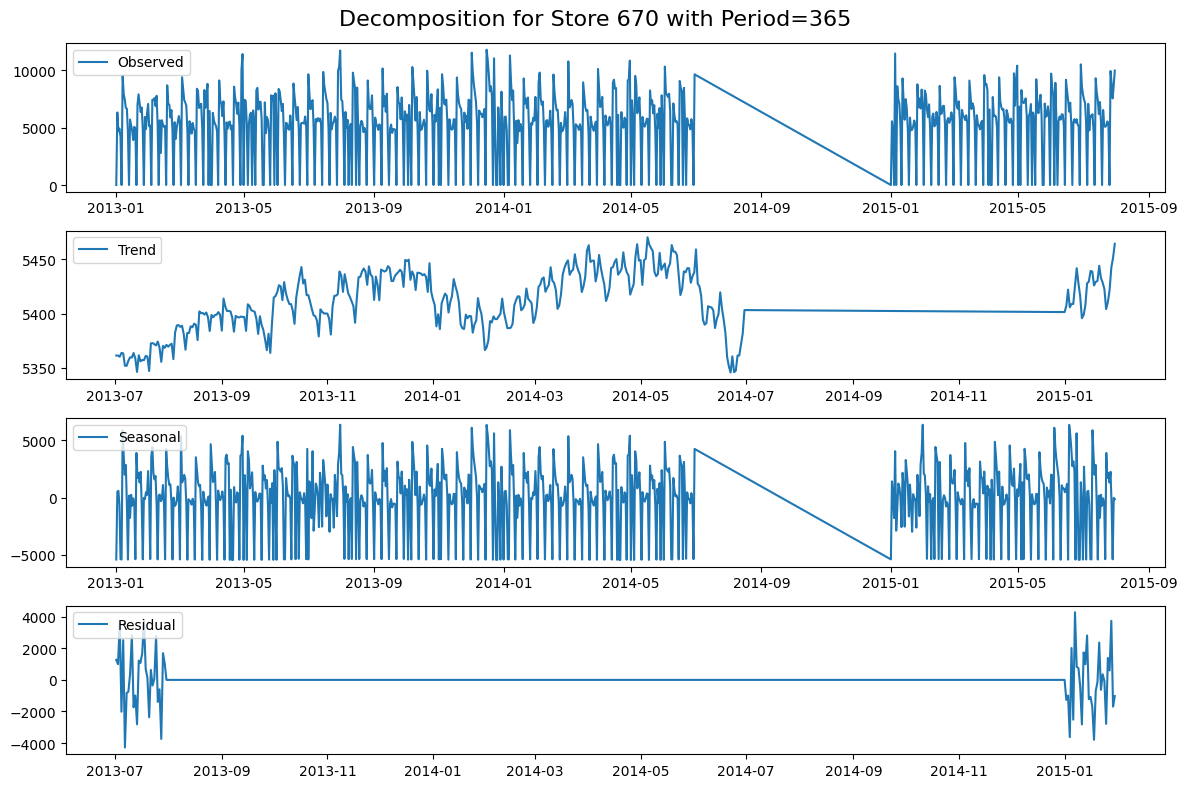

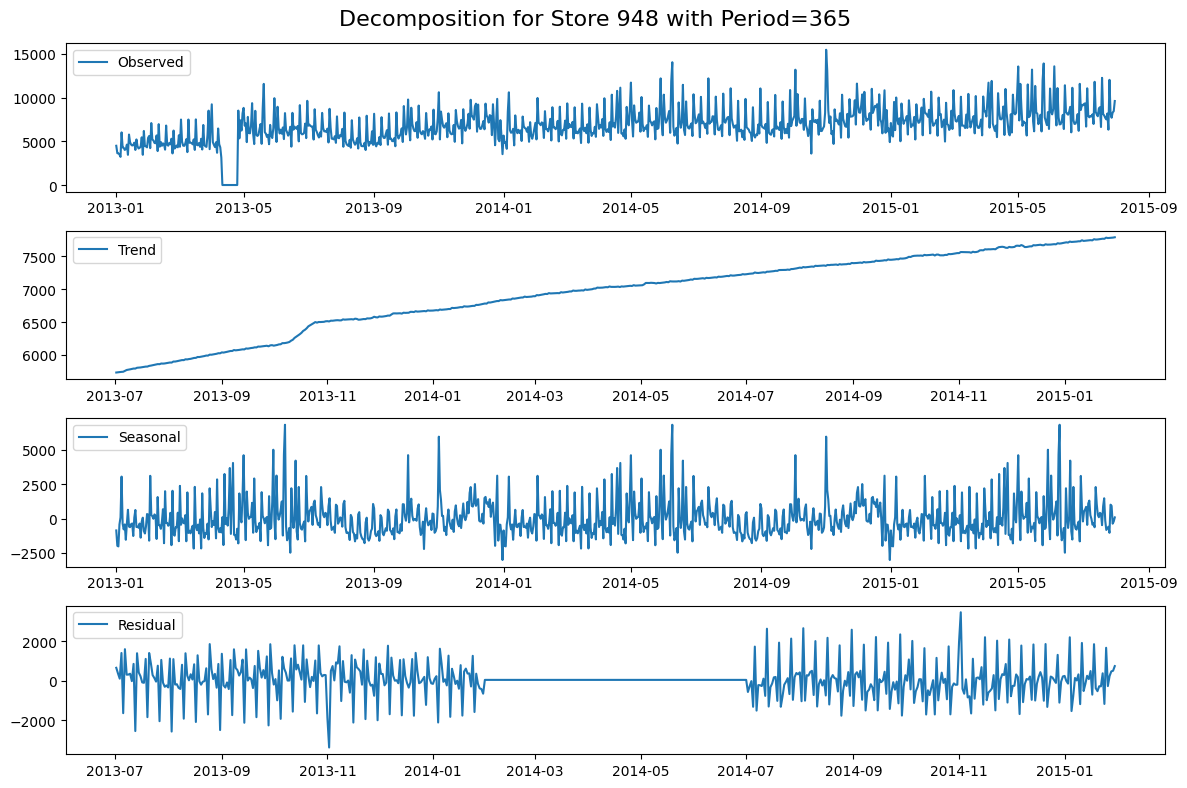

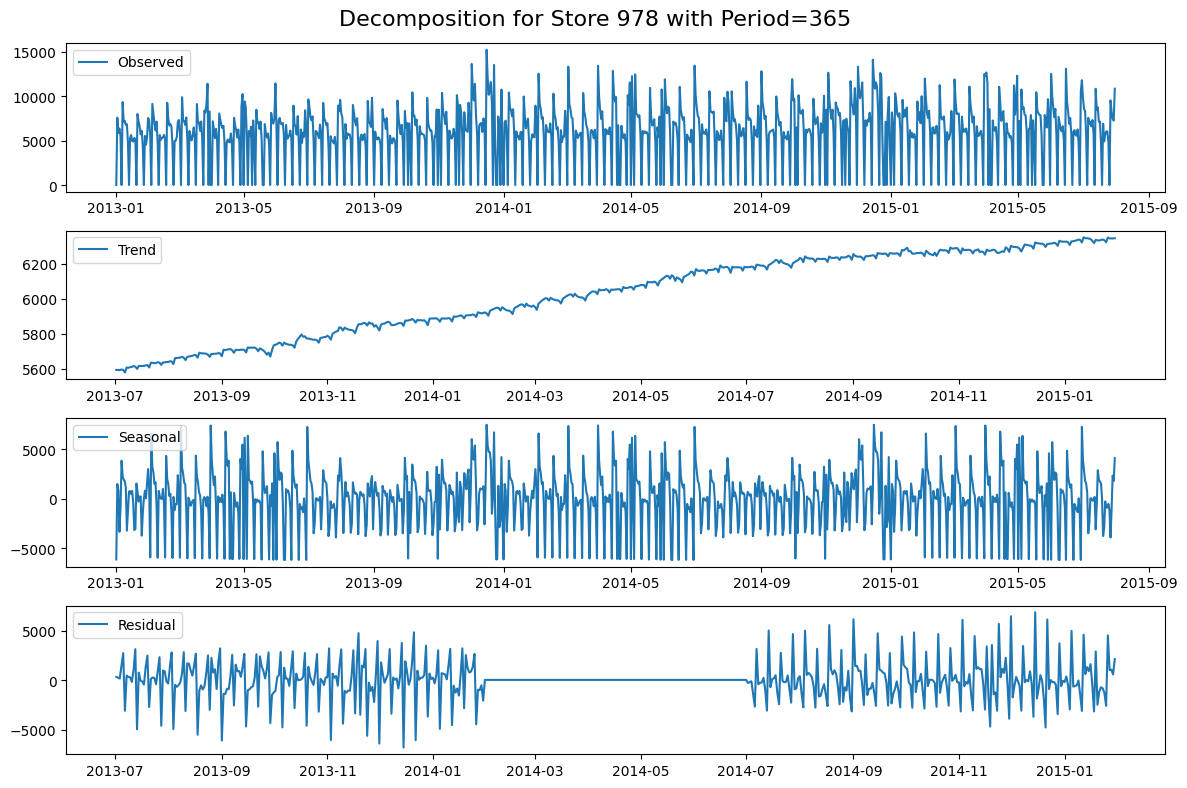

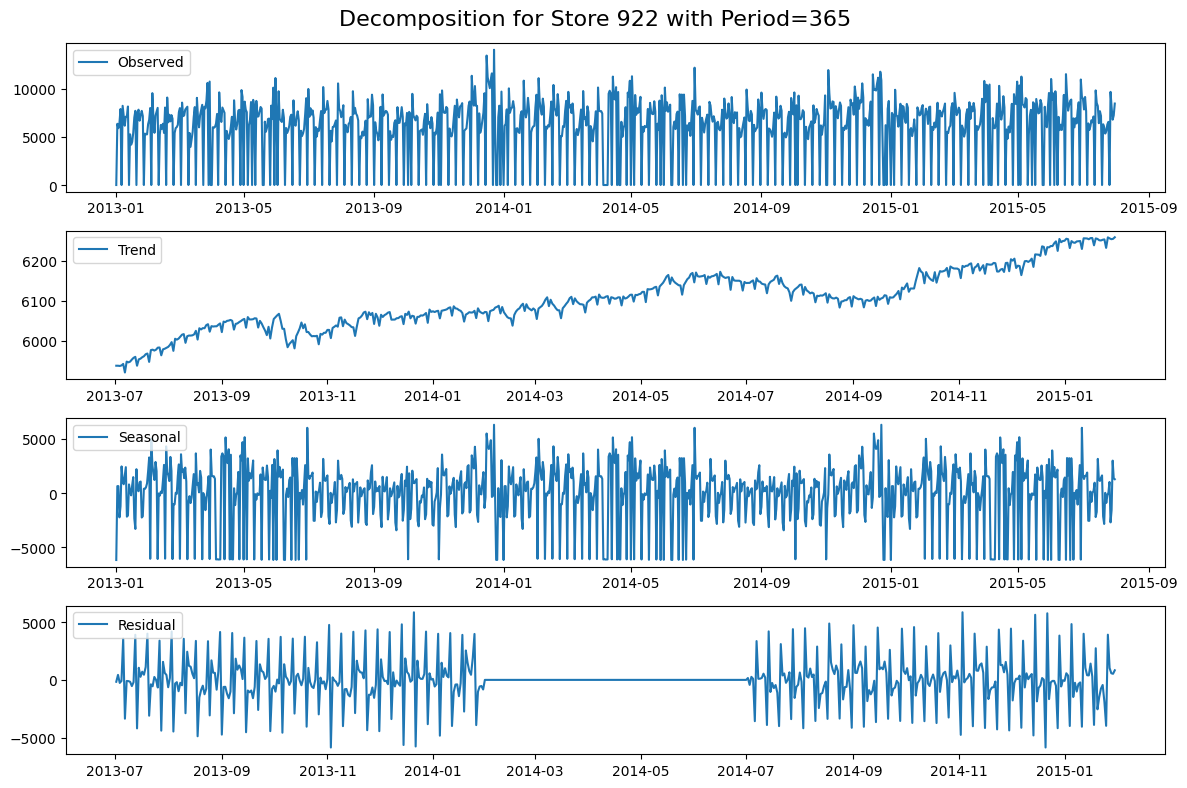

In [17]:
# Loop over each period
for period in periods_to_try:
    # Loop over each selected store
    for store_id in stores_to_analyze:
        # Filter data for the selected store
        store_data = train_df[train_df['Store'] == store_id]
        
        # Decompose the time series with the current period
        decomposition = seasonal_decompose(store_data['Sales'], model='additive', period=period)
        
        # Plot decomposed components
        plt.figure(figsize=(12, 8))
        plt.suptitle(f'Decomposition for Store {store_id} with Period={period}', fontsize=16)
        plt.subplot(411)
        plt.plot(decomposition.observed, label='Observed')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

**we can see that every store has different decomposition.**

# **From here i will choose one store and analyze it.**


## Decompose the Time Series

In [29]:
decomposition = seasonal_decompose(store_4_data['Sales'])

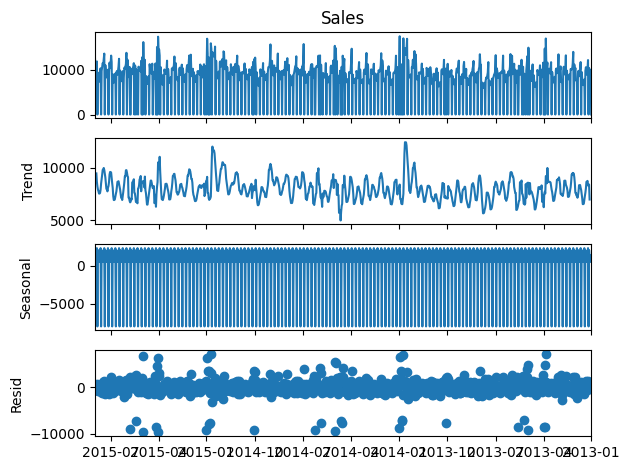

In [30]:
decomposition.plot()
plt.show()

In [18]:
store_4_data = train_df[train_df['Store'] == 4]

## Seasonality Analysis

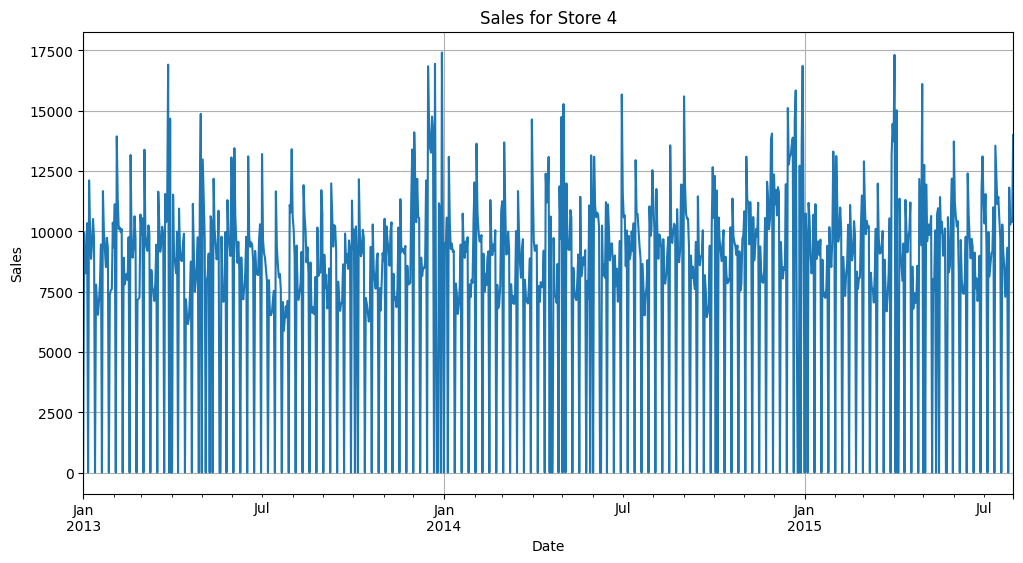

In [19]:
plt.figure(figsize=(12, 6))
store_4_data['Sales'].plot()
plt.title('Sales for Store 4')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

## Trend Analysis (using rolling mean)

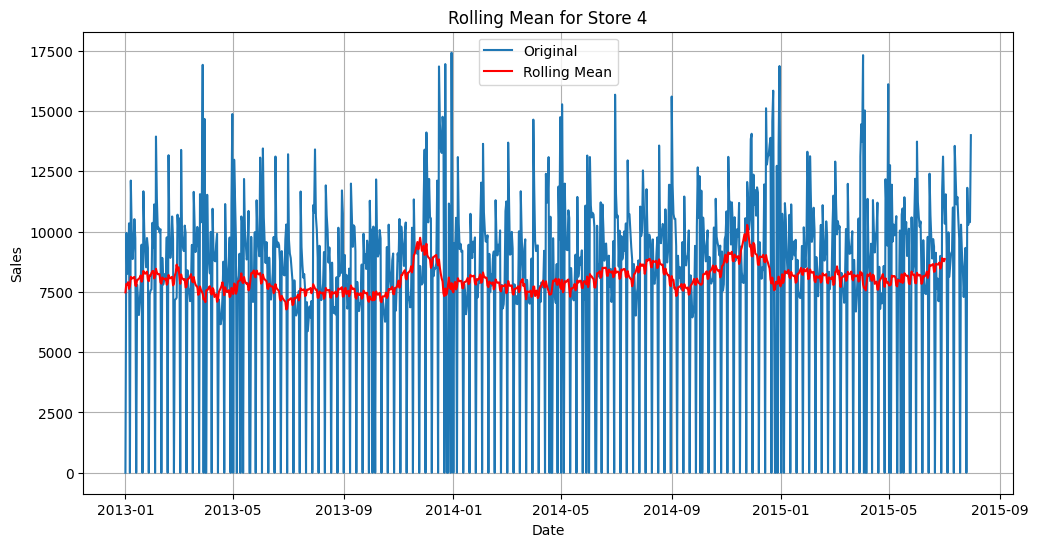

In [20]:
rolmean = store_4_data['Sales'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(store_4_data.index, store_4_data['Sales'], label='Original')
plt.plot(store_4_data.index, rolmean, color='red', label='Rolling Mean')
plt.title('Rolling Mean for Store 4')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Autocorrelation Analysis

<Figure size 1200x600 with 0 Axes>

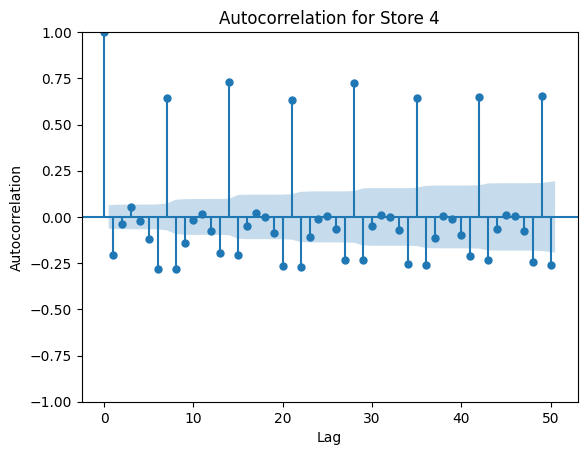

In [21]:

plt.figure(figsize=(12, 6))
plot_acf(store_4_data['Sales'], lags=50)
plt.title('Autocorrelation for Store 4')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

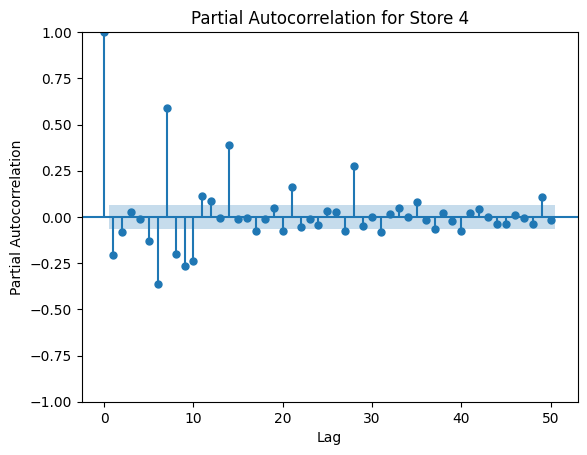

In [22]:
plt.figure(figsize=(12, 6))
plot_pacf(store_4_data['Sales'], lags=50)
plt.title('Partial Autocorrelation for Store 4')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


Based on the above analysis, the suggested ARIMA model parameters are:
* p=1
* q=1
* d=1

## Stationarity Check (using Augmented Dickey-Fuller test)

In [23]:
adf_result = adfuller(store_4_data['Sales'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -5.4438620247721285
p-value: 2.7380663953802715e-06
Critical Values:
	1%: -3.4374778690219956
	5%: -2.864686684217556
	10%: -2.5684454926748583


## Seasonal Decomposition and Analysis

<Figure size 2400x1200 with 0 Axes>

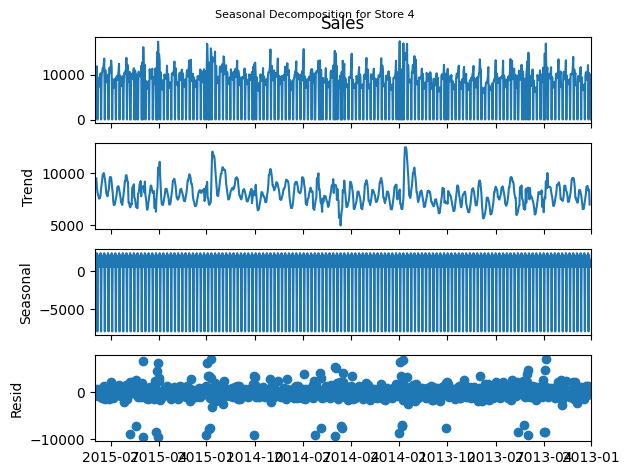

In [31]:
decomposition = seasonal_decompose(store_4_data['Sales'], model='additive', period=7)
plt.figure(figsize=(24, 12)) 
decomposition.plot()
plt.suptitle('Seasonal Decomposition for Store 4', fontsize=8)  
plt.show()


**From previous visulization we can see that:** 
* Trend Component >> is likely **additive** because it does not scale with time. 
* Seasonality Component >>  is also likely **additive** because its magnitude remains relatively constant over time.
* Residual Component >>  suggests an **additive** relationship because it fluctuates around a constant mean (zero), without variance scaling with the trend

## Rolling Statistics

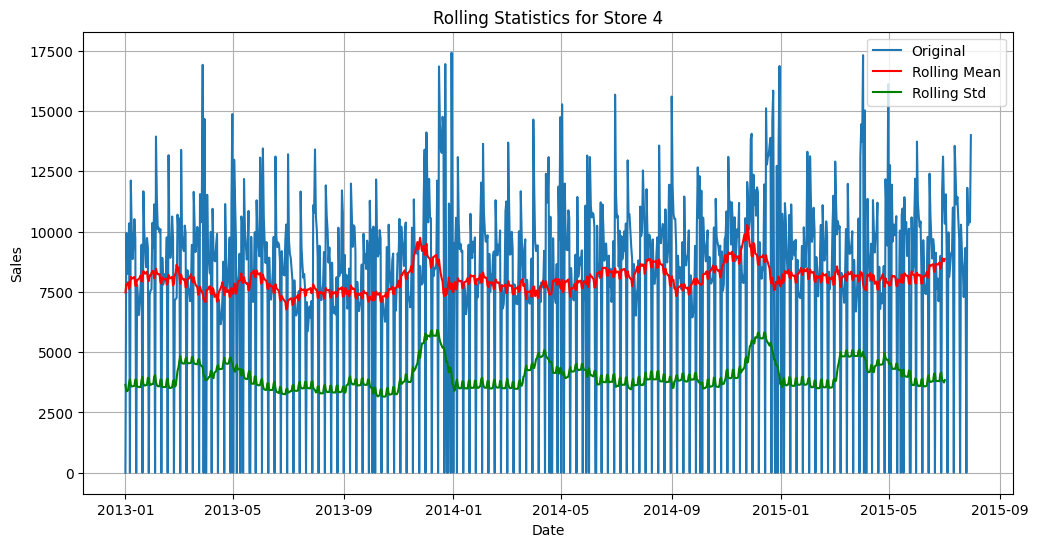

In [25]:
rolmean = store_4_data['Sales'].rolling(window=30).mean()
rolstd = store_4_data['Sales'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(store_4_data.index, store_4_data['Sales'], label='Original')
plt.plot(store_4_data.index, rolmean, color='red', label='Rolling Mean')
plt.plot(store_4_data.index, rolstd, color='green', label='Rolling Std')
plt.title('Rolling Statistics for Store 4')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()